<a href="https://colab.research.google.com/github/dorianxiao/DLexp/blob/master/Exp3%3A%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E8%AF%AD%E8%A8%80%E6%A8%A1%E5%9E%8B/PTB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 挂载到Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os

# 更改工作目录
os.chdir(r'/content/gdrive/My Drive/mylab/Exp3')
print(os.getcwd())

/content/gdrive/My Drive/mylab/Exp3


In [0]:
# 导入相关库

import tensorflow as tf
import numpy as np
import time
import math
import datetime
import collections
import matplotlib.pyplot as plt

tf.enable_eager_execution()

In [0]:
# 数据预处理
with open('./ptb.train.txt','r') as f1,open('./ptb.valid.txt','r') as f2,open(
    './ptb.test.txt','r') as f3:
    seq_train=f1.read().replace('\n','<eos>').split(' ')
    seq_valid=f2.read().replace('\n','<eos>').split(' ')
    seq_test=f3.read().replace('\n','<eos>').split(' ')

In [0]:
seq_train=list(filter(None,seq_train))
seq_valid=list(filter(None,seq_valid))
seq_test=list(filter(None,seq_test))

In [10]:
size_train=len(seq_train)
size_valid=len(seq_valid)
size_test=len(seq_test)
print('size_train {}, size_valid {}, size_test {}'.format(
    size_train, size_valid, size_test))

size_train 929589, size_valid 73760, size_test 82430


In [11]:
print(seq_train[:10])
print(seq_valid[:10])
print(seq_test[:10])

['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro-quebec']
['consumers', 'may', 'want', 'to', 'move', 'their', 'telephones', 'a', 'little', 'closer']
['no', 'it', 'was', "n't", 'black', 'monday', '<eos>', 'but', 'while', 'the']


In [0]:
# 建立词汇表

vocab_train=set(seq_train)
vocab_valid=set(seq_valid)
vocab_test=set(seq_test)

In [13]:
assert vocab_valid.issubset(vocab_train)
assert vocab_test.issubset(vocab_train)
print('vocab_train {}, vocab_valid {}, vocab_test {}'.format(
    len(vocab_train),len(vocab_valid),len(vocab_test)))

vocab_train 10000, vocab_valid 6022, vocab_test 6049


In [0]:
# 先将词汇表进行排序
vocab_train=sorted(vocab_train)

# 建立word2id和id2word字典
word2id={w:i for i,w in enumerate(vocab_train)}
id2word={i:w for i,w in enumerate(vocab_train)}

In [0]:
ids_train=np.array([word2id[word] for word in seq_train],copy=False,order='C')
ids_valid=np.array([word2id[word] for word in seq_valid],copy=False,order='C')
ids_test=np.array([word2id[word] for word in seq_test],copy=False,order='C')

In [0]:
def features_labels(data_array,batch_size,seq_len,batch_first=True):
  """Splits the sequential data into batch_size number of sub_sequences and 
  folds them into the requisite shape. This procedure is applied to the data to 
  derive the features array. This procedure is repeated to derive the labels 
  array also, except in this case the data is shifted by one time step. 
  Returns a named tuple of features and labels.
  
  Args:
    data_array: np.int64 1-d numpy array of shape (size,)
    batch_size: int;
    seq_len: int; length of the rnn layer
    batch_first: boolean; the returned numpy arrays will be of shape 
      (batch_size*steps, seq_len) if True and 
      (seq_len*steps, batch_size) if False
      
  Returns:
    named tuple of features and labels, features and labels are np.int64 2-d 
      numpy arrays of shape (batch_size*steps, seq_len) if batch_first is True 
      and (seq_len*steps, batch_size) if batch_first is False
    steps: int; number of mini batches in an epoch
      
  Raises:
    ValueError: If input data_array is not 1-d

  """
  if len(data_array.shape) != 1:
    raise ValueError('Expected 1-d data array, '
                     'instead data array shape is {} '.format(data_array.shape))
  
  def fold(used_array):
    shaped_array=np.reshape(used_array,(batch_size,seq_len*steps),order='C')
    
    if batch_first:
      return np.concatenate(np.split(shaped_array,steps,axis=1),axis=0)
    else:
      return np.transpose(shaped_array)

  steps=(data_array.shape[0]-1)//(batch_size*seq_len)
  used=batch_size*seq_len*steps
  
  features=fold(data_array[:used])
  labels=fold(data_array[1:used+1])
  
  Data=collections.namedtuple('Data',['features','labels'])
  return Data(features=features,labels=labels),steps

In [0]:
# 设置超参数

batch_size=20
seq_len=20
clip_norm=5
learning_rate=1.
decay=0.5
epochs=13
epochs_no_decay=4

In [0]:
data_train,steps_train=features_labels(
    ids_train,batch_size,seq_len,batch_first=False)
data_valid,steps_valid=features_labels(
    ids_valid,batch_size,seq_len,batch_first=False)
data_test,steps_test=features_labels(
    ids_test,batch_size,seq_len,batch_first=False)

In [0]:
# 构建数据集

dataset_train=tf.data.Dataset.from_tensor_slices(data_train).batch(seq_len,
    drop_remainder=True)
dataset_valid=tf.data.Dataset.from_tensor_slices(data_valid).batch(seq_len,
    drop_remainder=True)
dataset_test=tf.data.Dataset.from_tensor_slices(data_test).batch(seq_len,
    drop_remainder=True)

In [0]:
# 构建PTB对象

class PTBModel(object):
  """
  Ref: 
    Wojciech Zaremba, Ilya Sutskever, and Oriol Vinyals, 
    "Recurrent Neural Network Regularization", ICLR 2015
    
  Imports:
    tf
    tf.nn
    tf.math
    tf.contrib.cudnn_rnn.CudnnLSTM - requires GPU
    tf.layers.Dense
    tf.train.GradientDescentOptimizer
    tf.contrib.eager
  
  """
  
  def __init__(self, 
               vocab_size, 
               embedding_dim, 
               hidden_dim, 
               num_layers, 
               initializer, 
               dropout_ratio):
    """Initalizes a model instance. Configures network layers.
    
    Args:
      vocab_size: int;
      embedding_dim: int; 
      hidden_dim: int; hidden state size, cell state size
      num_layers: int; number of layers
      initializer: initializer object for initializing kernels and biases
      dropout_ratio: float; drop out ratio

    Returns:
      a model instance

    Raises:
      
    """
    self._embedding=tf.get_variable(
        'embedding',
        shape=(vocab_size, embedding_dim),
        initializer=initializer,
        trainable=True)
    
    #crashes when input_mode='skip_input' or 'auto_select'
    self._rnn=tf.contrib.cudnn_rnn.CudnnLSTM(
        num_layers=num_layers, 
        num_units=hidden_dim, 
        dropout=dropout_ratio,
        kernel_initializer=initializer,
        input_mode='linear_input')

    self._dense=tf.layers.Dense(
        units=vocab_size,        
        kernel_initializer=initializer)
        
    self._training=False
    self._state=None
    
  def _call(self,inp):
    """Executes a forward prop through the network.
    
    Args:
      inp: input (features) tf.int64 2-d tensor of shape (seq_len,batch_size)
      
    Returns:
      y: output logits tf.float32 3-d tensor of shape (seq_len,batch_size,
        vocab_size)
        
    Raises:
      
    """
    
    y=tf.nn.embedding_lookup(self._embedding, inp)     
    y,self._state=self._rnn(y,initial_state=self._state,training=self._training)
    y=self._dense(y)
    
    return y
  
  def _loss(self, inp, target):
    """Calls forward prop, gets logits, computes softmax, and calculates total
    cross-entropy loss for a mini batch.
    
    Args:
      inp: input (features) tf.int64 2-d tensor of shape (seq_len,batch_size)
      target: target (labels) tf.int64 2-d tensor of shape (seq_len,batch_size)
      
    Returns:
      loss: tf.float32 0-d tensor
        
    Raises:
      
    """
    
    y=self._call(inp)
    return tf.math.reduce_sum(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=target,logits=y))
  
  def train(self, iterator, clip_norm, optimizer):
    """Runs an epoch of training.
        
    Args:
      iterator: iterator object that yields (input,target) tuples where input  
        and target both are tf.int64 2-d tensors of shape (seq_len,batch_size)
      clip_norm: float; maximum global norm for clipping gradients
      optimizer: optimizer object for applying gradients
      
    Returns:
      A python list of losses, one loss (float) per step
      
    Raises:
    
    """
    self._training=True
    self._state=None
    losses=[]
    
    while True:
      try:
        inp,target=iterator.get_next()
        loss,grad_var=tf.contrib.eager.implicit_value_and_gradients(self._loss)(
            inp,target)
        losses.append(loss.numpy())
        
        gradients,variables=zip(*grad_var)
        clipped, global_norm=tf.clip_by_global_norm(gradients, clip_norm)
        grad_var=zip(clipped, variables)
        optimizer.apply_gradients(grad_var)
      except tf.errors.OutOfRangeError:
        break
        
    return losses
        
  def evaluate(self, iterator):
    """Runs an epoch of evaluation.
        
    Args:
      iterator: iterator object that yields (input,target) tuples where input 
        and target both are tf.int64 2-d tensors of shape (seq_len,batch_size)
      
    Returns:
      A python list of losses, one loss (float) per step
      
    Raises:
    
    """
    self._training=False
    self._state=None
    losses=[]
    
    while True:
      try:
        inp,target=iterator.get_next()       
        losses.append(self._loss(inp,target).numpy())
      except tf.errors.OutOfRangeError:
        break
        
    return losses

  @classmethod
  def instance(cls, model_type='small', vocab_size=10000):
    """Returns a model instance.
    
    Args:
      model_type: string; 'small', 'medium' or 'large'; only 'small' is
        implemented presently
      vocab_size: int;

    Returns:
      a model instance

    Raises:
      
    """
    return {
        'small':PTBModel(
            vocab_size=vocab_size,
            embedding_dim=200,
            hidden_dim=200,
            num_layers=2,
            initializer=tf.random_uniform_initializer(minval=-0.1,maxval=0.1),
            dropout_ratio=0.),
        'medium':None,
        'large':None
        }.get(model_type,None)

In [21]:
# 构建模型

model=PTBModel.instance(model_type='small',vocab_size=len(word2id))
lr=tf.contrib.eager.Variable(initial_value=learning_rate, trainable=False)
optimizer=tf.train.GradientDescentOptimizer(lr)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [22]:
start_time=time.time()
print('date {}'.format(datetime.datetime.now()))
print('device {}'.format(tf.test.gpu_device_name()))
print('TensorFlow vers. {}'.format(tf.__version__))

date 2019-05-27 08:35:34.156720
device /device:GPU:0
TensorFlow vers. 1.13.1



                        TRAINING
time      epochs         loss               perplexity
                    train    valid       train       valid
======    ======    =====    =====       =====       =====
Instructions for updating:
Colocations handled automatically by placer.
0:00:28     1.00     5.59     5.21      266.91      182.80
0:00:53     2.00     4.90     4.98      134.31      145.66
0:01:17     3.00     4.64     4.91      103.53      135.63
0:01:41     4.00     4.47     4.88       87.38      131.41
0:02:06     5.00     4.21     4.79       67.28      119.86
0:02:29     6.00     4.01     4.77       55.31      118.13
0:02:55     7.00     3.90     4.78       49.25      118.97
0:03:20     8.00     3.83     4.78       46.21      119.56
0:03:44     9.00     3.80     4.78       44.64      119.64
0:04:08    10.00     3.78     4.78       43.80      119.33
0:04:32    11.00     3.77     4.78       43.33      118.86
0:04:56    12.00     3.76     4.78       43.06      118.52
0:05:20    13

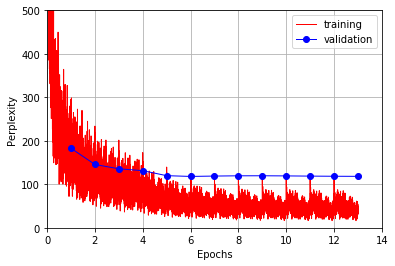


Loss/perplexity on test set after 13 epochs:     4.73/  113.25

execution time - 0:05:21s


In [23]:
perplexity_train=[]
perplexity_valid=[]

print('\n'+' '*24+'TRAINING'+'\n'+
      'time'+' '*6+
      'epochs'+' '*9+
      'loss'+' '*15+
      'perplexity'+'\n'+
      ' '*20+
      'train'+' '*4+
      'valid'+' '*7+
      'train'+' '*7+
      'valid'+'\n'+
      '======'+' '*4+
      '======'+' '*4+
      '====='+' '*4+
      '====='+' '*7+
      '====='+' '*7+
      '=====')

for epoch in range(epochs):
  iter_train=dataset_train.make_one_shot_iterator()
  losses_train=model.train(iter_train,clip_norm,optimizer)
  assert len(losses_train)==steps_train
  loss_train_avg=sum(losses_train)/(len(losses_train)*seq_len*batch_size)
  perplexity_train+=[(epoch+(step+1)/len(losses_train),math.exp(loss/(
      seq_len*batch_size))) for step,loss in enumerate(losses_train)]
  
  iter_valid=dataset_valid.make_one_shot_iterator()
  losses_valid=model.evaluate(iter_valid)
  assert len(losses_valid)==steps_valid
  loss_valid_avg=sum(losses_valid)/(len(losses_valid)*seq_len*batch_size)
  perplexity_valid.append((epoch+1,math.exp(loss_valid_avg)))
  
  if epoch>epochs_no_decay-2:
    lr.assign(lr*decay)

  print('{:}'.format(datetime.timedelta(seconds=round(time.time()-start_time))),
        '{:5.2f}'.format(epoch+1),
        '{:5.2f}'.format(loss_train_avg),
        '{:5.2f}'.format(loss_valid_avg),
        '{:8.2f}'.format(math.exp(loss_train_avg)),
        '{:8.2f}'.format(perplexity_valid[-1][1]),sep=' '*4)
  
plt.plot([loss[0] for loss in perplexity_train],
         [loss[1] for loss in perplexity_train],
         linewidth=1,color='red',label='training')
plt.plot([loss[0] for loss in perplexity_valid],
         [loss[1] for loss in perplexity_valid],
         linewidth=1,color='blue',label='validation', marker='o')
plt.grid(True,which='both',axis='both')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.axis([0,14,0,500])
plt.legend()
plt.show()

iter_test=dataset_test.make_one_shot_iterator()
losses_test=model.evaluate(iter_test)
assert len(losses_test)==steps_test
loss_test_avg=sum(losses_test)/(len(losses_test)*seq_len*batch_size)
print("\nLoss/perplexity on test set after {} epochs: {:8.2f}/{:8.2f}\n".format(
    epoch+1,loss_test_avg,math.exp(loss_test_avg)))

print("execution time - {}s".format(
    datetime.timedelta(seconds=round(time.time()-start_time))))